In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import relu, sigmoid, tanh, selu

import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
path = './path/ImageNet/data'

data = dsets.ImageFolder(root = path, transform = transforms.ToTensor())
print(len(data))

100000


In [ ]:
class_count = 10
# how many classes are we interested in classifying?

stop_point = 0
while data[stop_point+1][1] < class_count:
    stop_point += 1

data = Subset(data, np.arange(stop_point+1))
print(len(data))

5000


In [4]:
population = stop_point + 1 # change if you want to make smaller
data_subset_indeces = np.random.choice(range(len(data)), population, replace=False)
data = Subset(data, data_subset_indeces)

In [6]:
# now let's get our hands on a training set, test set, and validation set
train_num = int(len(data)*0.9)
train_indeces = np.random.choice(range(len(data)), train_num, replace=False)
test_and_val_indeces = np.array([i for i in range(len(data)) if i not in train_indeces])

test_num = int(len(test_and_val_indeces)*0.9)
test_indeces = Subset(test_and_val_indeces, np.random.choice(range(len(test_and_val_indeces)), test_num, replace=False))
val_indeces = np.array([i for i in test_and_val_indeces if i not in test_indeces])

print(len(data))
print(len(train_indeces))
print(len(test_indeces))
print(len(val_indeces))
print(len(train_indeces)+len(test_indeces)+len(val_indeces))

5000
4500
450
50
5000


In [7]:
train_set = Subset(data, train_indeces)
test_set = Subset(data, test_indeces)
val_set = Subset(data, val_indeces)

print(len(data))
print(len(train_set))
print(len(test_set))
print(len(val_set))
print(len(train_set)+len(test_set)+len(val_set))

5000
4500
450
50
5000


In [8]:
def class_set(data_set):
    
    values = []
    for i in range(len(data_set)):
        values.append(data_set[i][1])

    values.sort()
    # nlog(n) time complexity - the slowest task within this function 

    unique = [values[0]]
    i = 0
    while i < len(values) - 1:
        while i < len(values) - 1 and values[i+1] == values[i]:
            i += 1
        if i < len(values) - 1:
            unique.append(values[i+1])
        i += 1
    # now that values is sorted, we can iterate through and add to our list of unique classifications whenever we reach a new value
    # linear time

    return unique # all of the UNIQUE classifications

In [9]:
print(class_set(data))
print(class_set(train_set))
print(class_set(test_set))
print(class_set(val_set))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


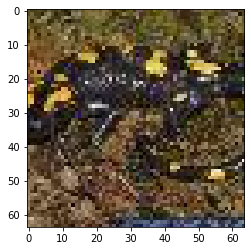

1


In [10]:
plt.imshow(train_set[0][0].permute(1,2,0)) # the image
plt.show()
print(train_set[0][1]) # classification

In [18]:
class CNN(nn.Module):
    
    
    def __init__(self, layers=[2500, 1250, 625, 350, 200, 100, 50, 25, class_count], convolutions=[(3,5,1,None), (1,5,1,None), (1,5,1,None), (1,5,1,None)]):
        
        super(CNN, self).__init__()
        # so that we can now call neural network modules
        
        self.initialized = False
        
        self.dims = layers
        
        
        self.convs = nn.ModuleList()
        for index, convolution in enumerate(convolutions):
            if index > 0:
                assert convolutions[index-1][2] == convolutions[index][0], f"Invalid input and output channel matching at convolutions {index-1} and {index}."
            
            if convolution[3] != None:
                conv = nn.Conv2d(in_channels=convolution[0], out_channels=convolution[2], kernel_size=convolution[1])
                maxpool = nn.MaxPool2d(convolution[3])
                self.convs.append(conv)
                self.convs.append(maxpool)
            else:
                conv = nn.Conv2d(in_channels=convolution[0], out_channels=convolution[2], kernel_size=convolution[1])
                self.convs.append(conv)
            # all of the convolutions that go at the start of our network
        
        self.linears = nn.ModuleList()
        for this_dim, next_dim in zip(layers, layers[1:]):
            self.linears.append(nn.Linear(this_dim, next_dim))
            # all of the weights and biases
            
        self.binary = layers[-1]==1
        # binary or multiclass output?
        
        
    def forward(self, x):
        
        x = x.type(torch.FloatTensor)
        # convert x to float
        
        for image_changer in self.convs:
            x = image_changer(x)
        # run all of the convolutions/maxpools on x
        
        # now we need to reshape x into one vector
        num_pixels = 1
        for num in x.shape[1:]:
            # I don't care about the NUMBER of images; only the number of pixels PER image
            num_pixels *= num
        
        x = x.view(-1, num_pixels)
        # roll out into one vector
        
        if not self.initialized:
            # then we need to get PyTorch to count the dimensions
            if self.dims[0] != x.shape[-1]:
                # then we need to create a linear function to force the fit
                new_linear = nn.Linear(x.shape[-1], self.dims[0])
                self.linears.insert(0, new_linear)
            self.initialized = True
            # now we ARE initialized - the network has seen some images
        
        for index, linear in enumerate(self.linears):
            if index == len(self.linears) - 1:
                # we ARE on the last layer
                if self.binary:
                    x = sigmoid(linear(x))
                    # run the linear function and apply sigmoid for the binary output
                else:
                    x = linear(x)
                    # otherwise for multi-class there is no activation on the output layer
            else:
                # we are NOT on the last layer
                x = relu(linear(x))
                # apply relu activation
        
        return x
        # return x
        
    
    def show_progression(self, x, value, print_all=False):
        # visually show the feedforward behavior of our network
        
        initial_x = copy.deepcopy(x)
        
        assert len(x.shape)==4 and x.shape[0]==1, "show_progression method will only deal with one image at once - if you think you only have one, wrap it in an outer tensor."
        assert self.initialized, "Network has not yet seen any images."
        
        print('Actual Value:')
        print(value)
        print('\n')
        
        print('Original Image:')
        plt.imshow(x[0].permute(1, 2, 0))
        plt.show()
        print(x.shape)
        # show the image
        
        x = x.type(torch.FloatTensor)
        # convert x to float
        
        conv_count = 0
        maxpool_count = 0
        
        for image_changer in self.convs:
            
            print('\n')
            
            if isinstance(image_changer, nn.Conv2d):
                conv_count += 1
                print(f'Convolution {conv_count}:')
            else:
                # then it is a maxpool
                maxpool_count += 1
                print(f'Max Pool {maxpool_count}:')
                
            x = image_changer(x)
            # now show the image 
            
            permuted = x.permute(1,0,2,3)
            # turn it into the dimensions necessary in order to show the image via matplotlib.pyplot
            for i in range(permuted.shape[0]):
                # sort of think of this as how many 'colors'/output channels
                plt.imshow(permuted.detach()[i].permute(1,2,0))
                plt.show()
                print("Shape", ":")
                print(x.shape)
            print('\n')
                
        # runs all of the convolutions and maxpools on x
        
        # now we need to reshape x into one vector
        num_pixels = 1
        for num in x.shape[1:]:
            # I don't care about the NUMBER of images; only the number of pixels PER image
            num_pixels *= num
        
        x = x.view(x.shape[0], num_pixels)
        # roll out into one vector (or a collection of vectors if multiple images)
        
        print('Unrolled Vector:')
        print(x.shape)
        
        if not self.initialized:
            # then we need to get PyTorch to count the dimensions
            if self.dims[0] != x.shape[-1]:
                # then we need to create a linear function to force the fit
                new_linear = nn.Linear(x.shape[-1], self.dims[0])
                self.linears.insert(0, new_linear)
            self.initialized = True
            # now we ARE initialized - the network has seen some images
        
        for index, linear in enumerate(self.linears):
            if index == len(self.linears) - 1:
                # we ARE on the last layer
                if self.binary:
                    x = sigmoid(linear(x))
                    # run the linear function and apply sigmoid for the binary output
                else:
                    x = linear(x)
                    # otherwise for multi-class there is no activation on the output layer
            else:
                # we are NOT on the last layer
                x = relu(linear(x))
                # apply relu activation
            
            print('\n')
            print(f'Hidden Layer {index}:')
            if print_all:
                print(x.detach().tolist())
            print(x.shape)
            
        print('\n')
        print('Prediction:')
        print(torch.max(self.forward(initial_x), axis=1)[1].item())

In [19]:
def train(model, train_set, batch_size, test_set, num_epochs, lr, file_path, overfit_path):
    
    if model.binary:
        # binary classification
        criterion = nn.BCELoss()
        # log of the probability
    else:
        # multi-class
        criterion = nn.CrossEntropyLoss()
        
    optimizer = optim.Adam(model.parameters(), lr)
    # responsible for updating our network weights and biases
    
    train = DataLoader(train_set, batch_size, shuffle=True)
    # (potentially depending on batch size) a bunch of smaller batches
    
    test = DataLoader(test_set, len(test_set))
    # one big batch
    
    LOSS = []
    ACCURACY = []
    # measure by the epoch
    
    checkpoints = [i for i in range(num_epochs) if (i % (num_epochs//10) == 0)]
    # 0%, 10%, 20% of the way there, etc.
    
    greatest_accuracy = 0
    # changes by the epoch
    
    for epoch in range(num_epochs):
        
        epoch_loss = 0
        
        # first we'll train the model slightly
        for x,y in train:
            # let's see how our loss is looking
            yhat = model(x)
            
            # DON'T DO ANY RESHAPING HERE
            
            loss = criterion(yhat, y)
            # we have the loss
            
            epoch_loss += loss.data
            # keep track of this batch's loss
            
            optimizer.zero_grad()
            # refresh the gradient
            
            loss.backward()
            # compute the gradient
            
            optimizer.step()
            # update the parameters
            
        LOSS.append(epoch_loss)
        
        # that is one epoch's worth of training
        # now to check on the accuracy
        
        for x,y in test:
            # one big batch - so this loop only runs once
            
            if not model.binary:
                # multi-class
                yhat = model(x)
                yhat = torch.max(yhat, axis=1)[1]
                # the index with the maximum value is the classification
            else:
                # binary
                yhat = model(x)
                yhat = yhat.view(-1,1)
                yhat = torch.round(yhat)
                # 0 --> one classification
                # 1 --> the other classification
            
            yhat = yhat.view(-1,1)
            y = y.view(-1,1)
            num_correct = torch.sum(yhat==y)
            # the number of images that were classified correctly
            accuracy = num_correct / len(test_set)
            # we can just create the variables here since this loop only runs once
        
        # AFTER EACH EPOCH
        ACCURACY.append(accuracy)
        
        if accuracy > greatest_accuracy:
            # broke the record
            greatest_accuracy = accuracy
            torch.save(model.state_dict(), file_path)
            # keep track of that model
        
        if epoch in checkpoints:
            # then announce that we're at a checkpoint
            print(f'{100*epoch//num_epochs}% through training...')
    
    # NOW all of the training has been completed
    
    torch.save(model.state_dict(), overfit_path)
    # the model with the most training, even if not the greatest accuracy
    
    plt.plot(LOSS, 'rx')
    plt.xlabel('Epoch Number')
    plt.ylabel('Training Loss')
    plt.title('Training Loss by the Epoch')
    plt.show()
    
    plt.plot(ACCURACY, 'go')
    plt.xlabel('Epoch Number')
    plt.ylabel('Testing Accuracy')
    plt.title('Testing Accuracy by the Epoch')
    plt.show()
    
# stores the trained and overfit model parameters into their respective 'txt' files

In [20]:
model = CNN()

In [21]:
train_duo = DataLoader(train_set, 2)
for x,y in train_duo:
    yhat = model(x)
    print(yhat)
    break

tensor([[-0.1046, -0.1586, -0.0350, -0.2182, -0.0503, -0.1765, -0.0963,  0.0107,
         -0.1140, -0.0516],
        [-0.1046, -0.1586, -0.0350, -0.2182, -0.0503, -0.1765, -0.0963,  0.0107,
         -0.1140, -0.0516]], grad_fn=<AddmmBackward0>)


Actual Value:
1


Original Image:


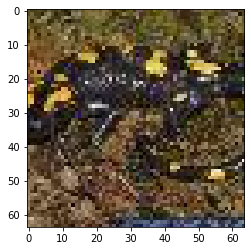

torch.Size([1, 3, 64, 64])


Convolution 1:


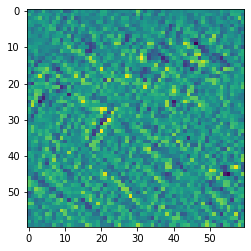

Shape :
torch.Size([1, 1, 60, 60])




Convolution 2:


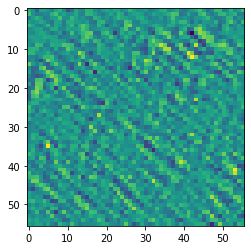

Shape :
torch.Size([1, 1, 56, 56])




Convolution 3:


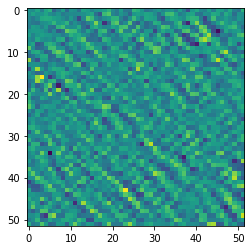

Shape :
torch.Size([1, 1, 52, 52])




Convolution 4:


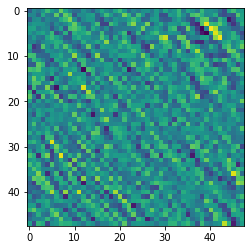

Shape :
torch.Size([1, 1, 48, 48])


Unrolled Vector:
torch.Size([1, 2304])


Hidden Layer 0:
torch.Size([1, 2500])


Hidden Layer 1:
torch.Size([1, 1250])


Hidden Layer 2:
torch.Size([1, 625])


Hidden Layer 3:
torch.Size([1, 350])


Hidden Layer 4:
torch.Size([1, 200])


Hidden Layer 5:
torch.Size([1, 100])


Hidden Layer 6:
torch.Size([1, 50])


Hidden Layer 7:
torch.Size([1, 25])


Hidden Layer 8:
torch.Size([1, 10])


Prediction:
7


In [22]:
array = train_set[0][0].detach().numpy()
tensor = torch.tensor(np.array([array]))
model.show_progression(tensor, train_set[0][1])

0% through training...
10% through training...
20% through training...
30% through training...
40% through training...
50% through training...
60% through training...
70% through training...
80% through training...
90% through training...


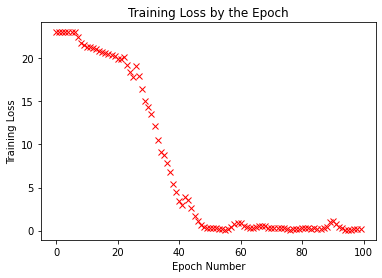

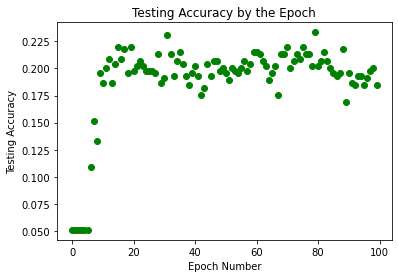

In [24]:
batch_size = int(len(train_set) / 10)
num_epochs = 100
lr = 0.002
file_path = "./model.txt"
overfit_path = "./overfit.txt"

train(model, train_set, batch_size, test_set, num_epochs, lr, file_path, overfit_path)

In [25]:
best_model = CNN()
array = train_set[0][0].numpy()
array = np.array([array])
# add another dimension
initializer = best_model(torch.tensor(array))
# to make sure the dimensions match from the convolution to the hidden layer
best_model.load_state_dict(torch.load("./model.txt"))
best_model.eval()

CNN(
  (convs): ModuleList(
    (0): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (3): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  )
  (linears): ModuleList(
    (0): Linear(in_features=2304, out_features=2500, bias=True)
    (1): Linear(in_features=2500, out_features=1250, bias=True)
    (2): Linear(in_features=1250, out_features=625, bias=True)
    (3): Linear(in_features=625, out_features=350, bias=True)
    (4): Linear(in_features=350, out_features=200, bias=True)
    (5): Linear(in_features=200, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=25, bias=True)
    (8): Linear(in_features=25, out_features=10, bias=True)
  )
)

In [26]:
def get_accuracy(model, test_set):
    
    test = DataLoader(test_set, len(test_set))
    # one big batch
    
    for x,y in test:
        # one big batch - so this loop only runs once

        if not model.binary:
            # multi-class
            yhat = model(x)
            yhat = torch.max(yhat, axis=1)[1]
            # the index with the maximum value is the classification
        else:
            # binary
            yhat = model(x)
            yhat = yhat.view(-1,1)
            yhat = torch.round(yhat)
            # 0 --> one classification
            # 1 --> the other classification

        yhat = yhat.view(-1,1)
        y = y.view(-1,1)
        num_correct = torch.sum(yhat==y)
        # the number of images that were classified correctly
        accuracy = num_correct / len(test_set)
        # we can just create the variables here since this loop only runs once
    
    return accuracy.item()

In [27]:
print(get_accuracy(best_model, test_set))

0.23333333432674408


In [28]:
print(get_accuracy(best_model, train_set))

0.9975555539131165


In [29]:
overfit_model = CNN()
array = train_set[0][0].numpy()
array = np.array([array])
# add another dimension
initializer = overfit_model(torch.tensor(array))
# to make sure the dimensions match from the convolution to the hidden layer
overfit_model.load_state_dict(torch.load("./overfit.txt"))
overfit_model.eval()

CNN(
  (convs): ModuleList(
    (0): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (3): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  )
  (linears): ModuleList(
    (0): Linear(in_features=2304, out_features=2500, bias=True)
    (1): Linear(in_features=2500, out_features=1250, bias=True)
    (2): Linear(in_features=1250, out_features=625, bias=True)
    (3): Linear(in_features=625, out_features=350, bias=True)
    (4): Linear(in_features=350, out_features=200, bias=True)
    (5): Linear(in_features=200, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=25, bias=True)
    (8): Linear(in_features=25, out_features=10, bias=True)
  )
)

In [30]:
print(get_accuracy(overfit_model, test_set))

0.18444444239139557


In [31]:
print(get_accuracy(overfit_model, train_set))

0.995555579662323


In [32]:
random_model = CNN()
print(get_accuracy(random_model, train_set))
print(get_accuracy(random_model, test_set))

0.10199999809265137
0.08444444090127945
